# Overfitting and Regularization

## Part 3: Homework assignment (10 points)

In [1]:
import numpy as np
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from matplotlib import pyplot as plt

In [2]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(42)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()

In [3]:
ALPHAS = np.linspace(0.01, 4, 20)
degree = 15
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
X, y = generate_samples()

### Excercise 1 - Magnitude (4 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

Логика проверки влияния регуляризации на веса: обучаем классификатор при различных значениях коэффициента регуляризации (alpha), получаем сумму весов для каждого случая, строим график зависимости суммы весов от alpha и смотрим на зависимость. Для этого задания оценка классификатора не требуется, поэтому обучаем на всех данных без разбиения на train/test

#### L1

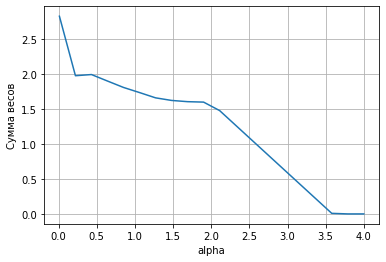

In [4]:
coef_list = []
for alpha in ALPHAS:
    clf = Pipeline([
        ('pol', PolynomialFeatures(degree)),
        ('sca', StandardScaler()),
        ('reg', Lasso(alpha = alpha, random_state = 42, max_iter=50000)) ])
    clf.fit(X, y)
    coef_list.append((np.sum(clf[2].coef_)))
plt.plot(ALPHAS, coef_list)
plt.grid(True)
plt.xlabel('alpha')
plt.ylabel('Сумма весов');

#### L2

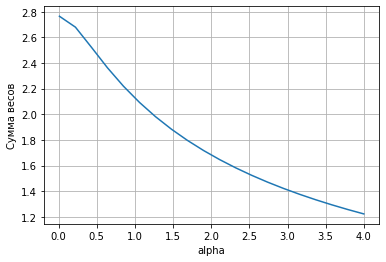

In [5]:
coef_list = []
for alpha in ALPHAS:
    clf = Pipeline([
        ('pol', PolynomialFeatures(degree)),
        ('sca', StandardScaler()),
        ('reg', Ridge(alpha = alpha, random_state = 42, max_iter=50000)) ])
    clf.fit(X, y)
    coef_list.append((np.sum(clf[2].coef_)))
plt.plot(ALPHAS, coef_list)
plt.grid(True)
plt.xlabel('alpha')
plt.ylabel('Сумма весов');

В обоих случаях видим уменьшение суммы весов при увеличении коэффициента регуляризации.  
**Вывод**: как L1, так и L2 регуляризация ограничивает веса.

### Excercise 2 - Sparsity (4 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

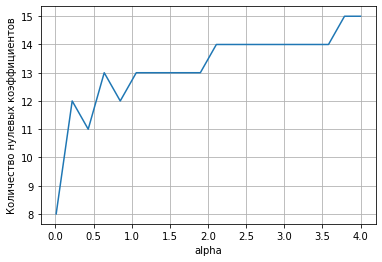

In [6]:
coef_list = np.array([])
zero_els = []
for alpha in ALPHAS:
    clf = Pipeline([
        ('pol', PolynomialFeatures(degree)),
        ('sca', StandardScaler()),
        ('reg', Lasso(alpha = alpha, random_state = 42, max_iter=50000)) ])
    clf.fit(X, y)
    coef_list = np.append(coef_list, clf[2].coef_)
    zero_els.append(np.count_nonzero(coef_list == 0) - 1)
    coef_list = np.array([])
    
plt.plot(ALPHAS, zero_els)
plt.grid(True)
plt.xlabel('alpha')
plt.ylabel('Количество нулевых коэффициентов');

#### L2

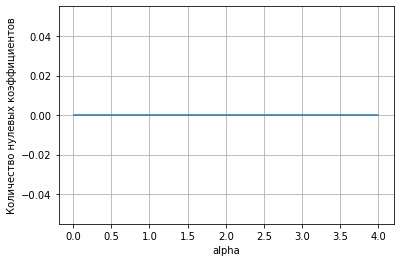

In [7]:
coef_list = np.array([])
zero_els = []
for alpha in ALPHAS:
    clf = Pipeline([
        ('pol', PolynomialFeatures(degree)),
        ('sca', StandardScaler()),
        ('reg', Ridge(alpha = alpha, random_state = 42, max_iter=50000)) ])
    clf.fit(X, y)
    coef_list = np.append(coef_list, clf[2].coef_)
    zero_els.append(np.count_nonzero(coef_list == 0) - 1)
    coef_list = np.array([])
    
plt.plot(ALPHAS, zero_els)
plt.grid(True)
plt.xlabel('alpha')
plt.ylabel('Количество нулевых коэффициентов');

#### Summary

По графикам видно, что в случае **L1** регуляризации при увеличении alpha количество нулевых коэффициентов увеличивается, а при высоком альфа зануляются вообще все коэффициенты, что явно не способствует улучшению качества модели.  
  
Для **L2** регуляризации количество нулевых коэффициентов равно нулю для всех значений альфа. Такое поведение мы и ожидали

### Excercise 3 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Why is scaling important? What are the underlying reasons?

Масштабирование признаков позволяет как улучшить качество обучения модели, так и её интерпретируемость. Например, если значения признаков различаются на порядок или больше, веса при этих признаках также будут сильно отличаться. При этом судить о значимости каждого признака по его весу не получится. Если признаки отмасштабированы, значимость можно оценить по весу признака.  
  
Для примера: ниже два графика RMSE, в первом случае в пайплайне есть скейлер, во втором нет. Во втором случае можно заподозрить неладное по количеству предупреждений при обучении, да и в целом обучение модели проходит менее стабильно, что видно на графике.

In [8]:
# Для этого примера необходима оценка качества, поэтому разбиваем на train/test
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

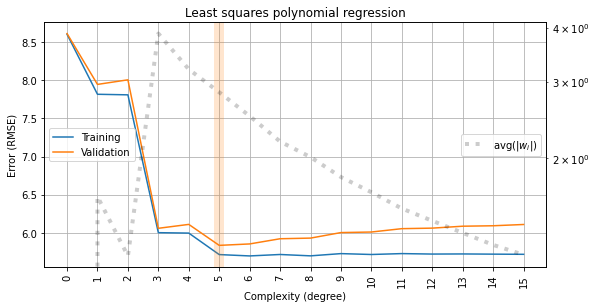

In [9]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    clf = Pipeline([
        ('pol', PolynomialFeatures(degree)),
        ('sca', StandardScaler()),
        ('reg', Ridge(alpha = alpha, random_state = 42, max_iter=50000)) ])
    results = cross_validate(clf,
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

/home/darean/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.18417e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/darean/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.36174e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/darean/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.96734e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/darean/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.62828e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/darean/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.30964e-18): r

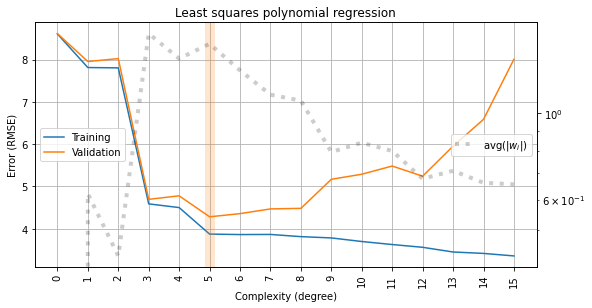

In [10]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    clf = Pipeline([
        ('pol', PolynomialFeatures(degree)),
        #('sca', StandardScaler()), убираем скейлер из пайплайна, смотрим результат
        ('reg', Ridge(alpha = alpha, random_state = 42, max_iter=50000)) ])
    results = cross_validate(clf,
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')